This code uses built-in functions from the Image class in PIL to execute isometries on a given image. It snapshots the lens view after each isometry, then puts those images into a numpy array. It then calculates the persistent homology of the data. For different images, 'lens_sz' and 'intervals' should be adjusted.

In [2]:
# Imports
import numpy as np
import math
from hausdorff import hausdorff_distance
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances

# For image and video manipulation
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageFilter
import PIL
import glob

# Persistent homology
from ripser import ripser
from persim import plot_diagrams
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from gudhi.cover_complex import MapperComplex, GraphInducedComplex, NerveComplex
from gudhi import bottleneck_distance
import gudhi as gd
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
 

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Grab image from files
c1_names = glob.glob('../images/*C1*.png')
c4_names = glob.glob('../images/*C4*.png')
test_name = glob.glob('../images/test*.png')
print(c1_names)
print(c4_names)
img = Image.open(c1_names[5])
img = img.convert('L')

img2 = Image.open(c1_names[5])
img2 = img2.convert('L')
img2 = img2.resize((3809*3,1614*3), resample = PIL.Image.Resampling.BOX)

img3 = Image.open(c1_names[4])
img4 = Image.open(c4_names[0])
img4 = img4.convert('L')

testimg = Image.open(test_name[0]).convert('L')
#img = img.resize((540,331), resample = PIL.Image.Resampling.BOX)
#img = ImageEnhance.Sharpness(img.convert('RGB'))
#img = img.enhance(0.1)
#img = img.filter(ImageFilter.GaussianBlur(1))
# with np.printoptions(threshold=np.inf):
#     print(np.asarray(img))
#img.show()

['../images\\C1 curly arrow.png', '../images\\C1 horsehex.png', '../images\\C1 horseshoe.png', '../images\\C1 spiral.png', '../images\\C1arrows.png', '../images\\C1bigarrows.png']
['../images\\C4pinwheel.png']


In [5]:
# wrapper for hausdorff so we can feed it into ripser
def hausdorff_wrapper(lensSize, metric='manhattan'):
    (x, y) = lensSize
    def second_layer(arrayOne, arrayTwo):
        arrayOne = arrayOne.reshape((y,x))
        arrayTwo = arrayTwo.reshape((y,x))
        return hausdorff_distance(arrayOne, arrayTwo, distance=metric)
    return second_layer

In [6]:
# def hausdorff_test(lensSize, metric='manhattan'):
#     (x, y) = lensSize
#     def second_layer(arrayOne, arrayTwo):
#         arrayOne = arrayOne.reshape((y,x))
#         Image.fromarray(arrayOne).show()
#         arrayTwo = arrayTwo.reshape((y,x))
#         return hausdorff_distance(arrayOne, arrayTwo, distance=metric)
#     return second_layer
# test_img = img4.crop((0,0,20,30))
# test_img.show()
# test_arr = np.asarray(test_img)
# hausdorff_test((20,30))(test_arr, test_arr)

In [7]:
# if you want to store generated images in a file
def store_snapshots(image_ls):
    counter = 0
    for img1 in image_ls:
        img1.save("images/dataset/"+str(counter)+".png")
        counter+=1

In [8]:
# see how many points are persisting
def persistingPoints(res,simpDim = 1):
    Hn = res['dgms'][simpDim].tolist() # all intervals in simpDim
    d = []
    for pair in Hn: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in Hn
    d.sort(reverse = True) # sorting from longest to shortest intervals
    print(d[:6])

translation_snapshot() translates the plane by a vector a and returns the lens view afterwards. It takes an image (Image), the lens size (int), and the translation vector (tuple) that shifts the plane in the direction of the vector. 

In [9]:
def translation_snapshot(img, lens_sz, a):
    (x,y)=a
    (lx, ly) = lens_sz
    x=-x #since x and y will shift the crop and not the plane, need to make sure it is going in right direction
    (length, height) = img.size
    lens_corner_x=length/2.0 - lx/2.0 +x
    lens_corner_y=height/2.0 - ly/2.0 +y
    ret_img = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lx, lens_corner_y+ly))
    
    #make sure didn't fall off of the image
    (ret_length, ret_height) = ret_img.size
#     if (lens_corner_x<0 or lens_corner_y<0 or lens_corner_x+lx>length or lens_corner_y+ly>height):
#         print("I came off the page!")
#         return False
    return ret_img

In [10]:
def fixedIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = np.linspace(0, 360, degree_num)
    intervals_x = np.linspace((-1)*lens_range, lens_range, translation_num)
    intervals_y = np.linspace((-1)*lens_range, lens_range, translation_num)
    
    for d in degrees:
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        #print(d)
        for x in intervals_x:
            for y in intervals_y:
                if lens_crunch == False:
                        image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
                else:
                        image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                          math.ceil(lens_sz / crunch_kernel)),
                                                                                         resample = PIL.Image.Resampling.BOX))

    for j in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    return image_list

In [11]:
def transIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = np.linspace(0, 360, degree_num)
    
    for d in degrees:
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        #print(d)
        for j in range(translation_num):
            x = rng.integers((-1)*lens_range, lens_range)
            y = rng.integers((-1)*lens_range, lens_range)
            if lens_crunch == False:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
            else:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))

    for j in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    return image_list

In [12]:
def randIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = rng.uniform(0.0,360.0, size = degree_num)
    j = 0
    
    for d in degrees:
        #print(j)
        j = j + 1
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    for k in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    return image_list

In [13]:
def imgListToArray(img_list):
    data = []
    x=0
    for i in image_list:
        img_arr = np.asarray(i)
        data.append(img_arr.reshape(-1))
    data = np.array(data)
    return data

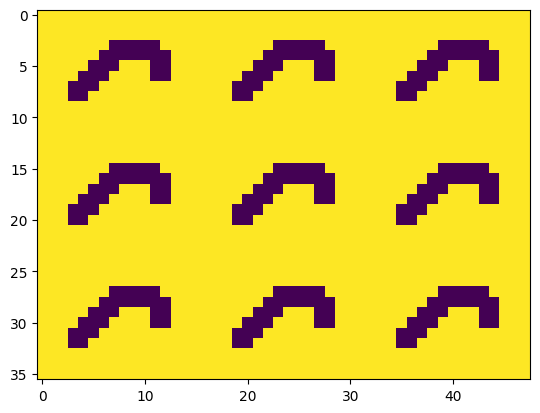

In [14]:
plt.figure()
plt.imshow(testimg)
plt.show()

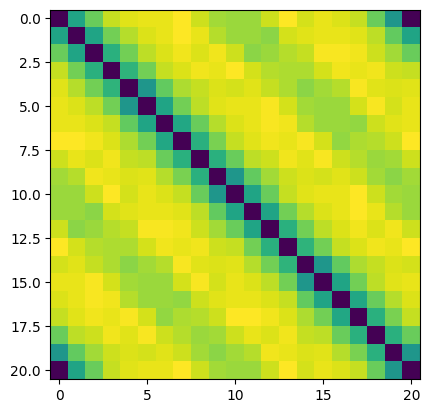

In [20]:
# classic: 18 degree step, 20 rotations
rot5 = []
j = np.arange(0,361,18)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.NEAREST)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5)
plt.figure()
plt.imshow(D)
plt.show()

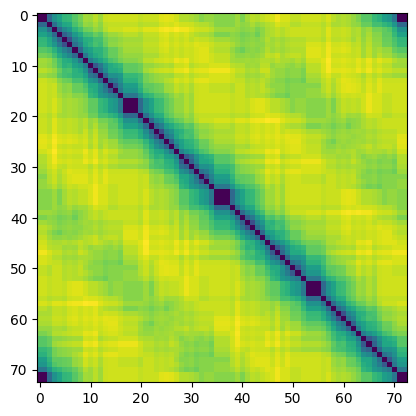

In [17]:
# increased fidelity, 5 degree step
rot5 = []
j = np.arange(0,361,5)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.NEAREST)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5)
plt.figure()
plt.imshow(D)
plt.show()

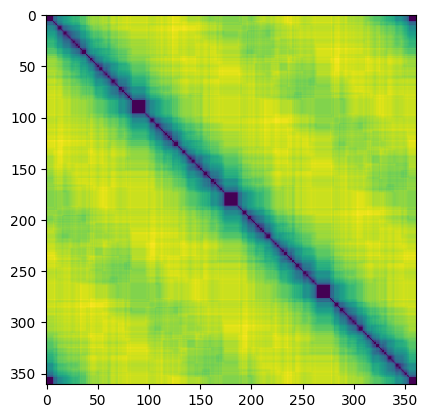

In [19]:
# 1 degree step
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.NEAREST)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5)
plt.figure()
plt.imshow(D)
plt.show()

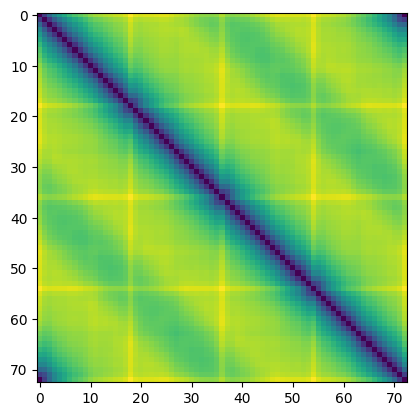

In [23]:
# Bilinear resampling -- looks cleaner, i think orthogonal artifacts are the product of perfect rotations at 90, 180
# 270, 360 (no resampling needed at these angles)
rot5 = []
j = np.arange(0,361,5)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.BILINEAR)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5)
plt.figure()
plt.imshow(D)
plt.show()

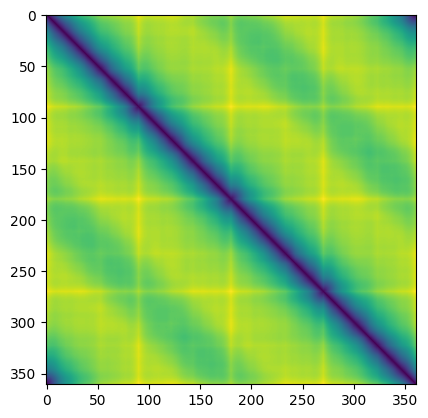

In [24]:
# Bilinear resampling higher res
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.BILINEAR)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5)
plt.figure()
plt.imshow(D)
plt.show()

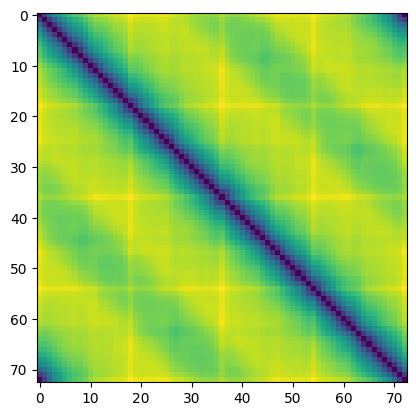

In [15]:
# Bicubic resampling
rot5 = []
j = np.arange(0,361,5)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5)
plt.figure()
plt.imshow(D)
plt.show()

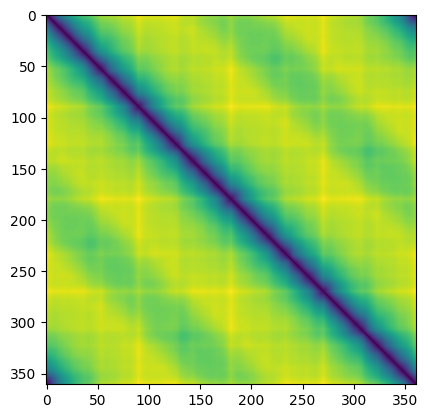

In [16]:
# Bicubic resampling hi res
# seems to be a sort of sub grid forming, these are probably angles with cleaner rotations?
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5)
plt.figure()
plt.imshow(D)
plt.show()

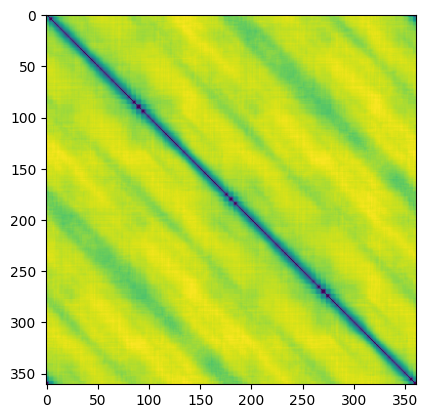

In [17]:
# nearest with bigger lense (double size)
# the appearance of multiple "hallucinations?"
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.NEAREST)
    shower = translation_snapshot(temp, (32,24),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5)
plt.figure()
plt.imshow(D)
plt.show()

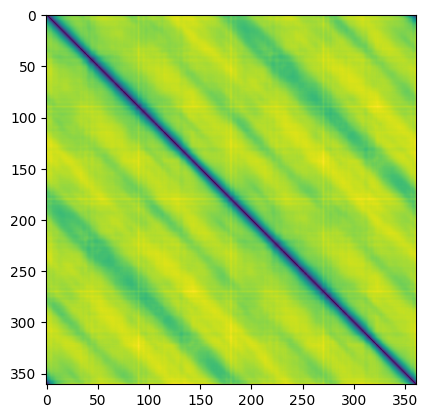

In [18]:
# Bicubic resampling big lense
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (32,24),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5)
plt.figure()
plt.imshow(D)
plt.show()

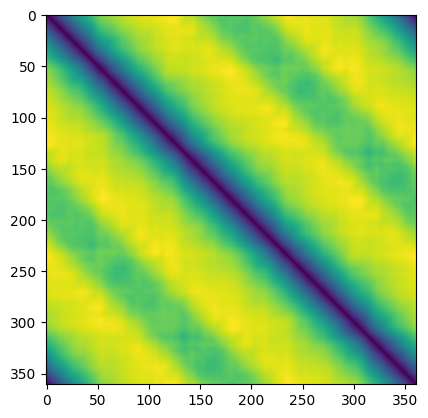

In [19]:
# Bicubic resampling manhattan
# from now on bicubic will be the default resampling in these tests
# seems to have cleaner lines
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5, metric = 'manhattan')
plt.figure()
plt.imshow(D)
plt.show()

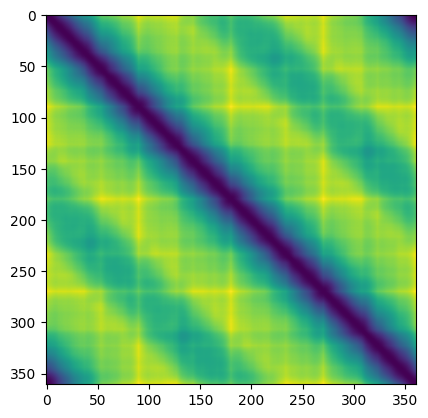

In [20]:
# Bicubic resampling cosine -- bad choice
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5, metric = 'cosine')
plt.figure()
plt.imshow(D)
plt.show()

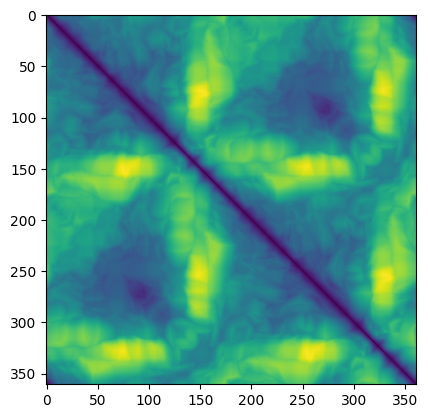

In [21]:
# Bicubic resampling hausdorff w/ manhattan -- this looks cool but seems bad
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5, metric = hausdorff_wrapper((16,12), metric='manhattan'))
plt.figure()
plt.imshow(D)
plt.show()

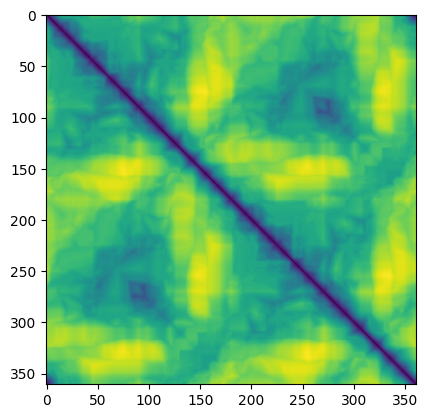

In [27]:
# Bicubic resampling hausdorff w/ euclidean
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5, metric = hausdorff_wrapper((16,12), metric='euclidean'))
plt.figure()
plt.imshow(D)
plt.show()

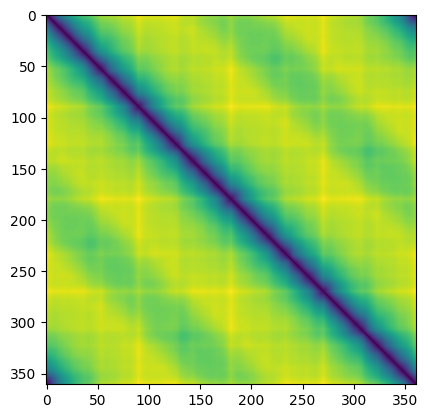

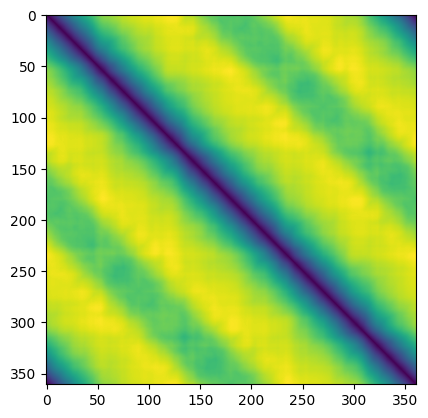

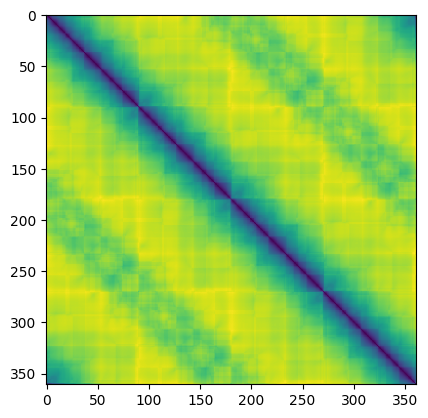

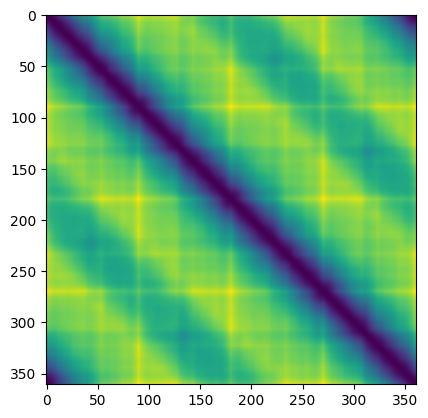

In [26]:
# Bicubic resampling other metrics...
# bray curtis actually looks decent, I don't closely understand the metric
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5, metric = 'minkowski')
plt.figure()
plt.imshow(D)
plt.show()
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5, metric = 'braycurtis')
plt.figure()
plt.imshow(D)
plt.show()
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5, metric = 'canberra')
plt.figure()
plt.imshow(D)
plt.show()

rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5, metric = 'sqeuclidean')
plt.figure()
plt.imshow(D)
plt.show()

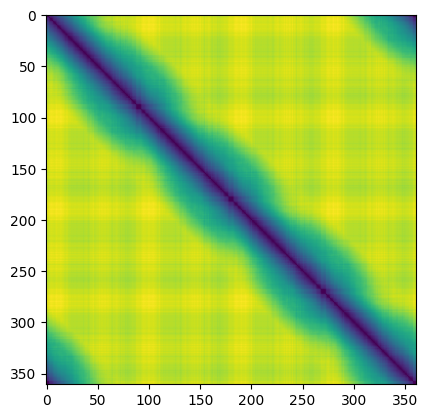

In [28]:
# Bicubic resampling with different image -- no hallucinations, still grid oddity. lense same size of arrow in image
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = img3.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (30,30),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5, metric = 'manhattan')
plt.figure()
plt.imshow(D)
plt.show()

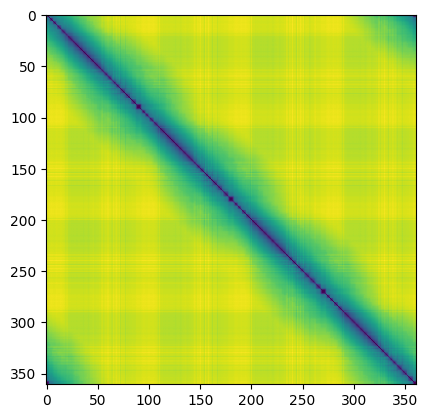

In [30]:
# now with euclidean
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = img3.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (30,30),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5, metric = 'euclidean')
plt.figure()
plt.imshow(D)
plt.show()

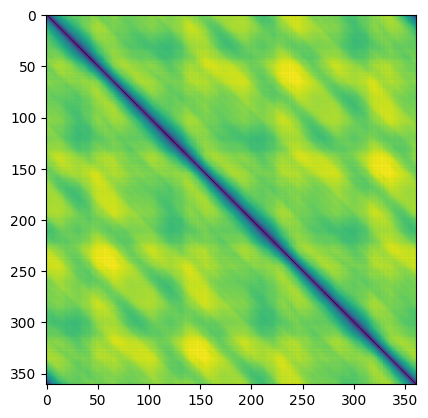

In [29]:
# Bicubic resampling bigger lense -- suddenly hallucinations reappear but might just be too noisy
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = img3.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (100,100),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5, metric = 'manhattan')
plt.figure()
plt.imshow(D)
plt.show()

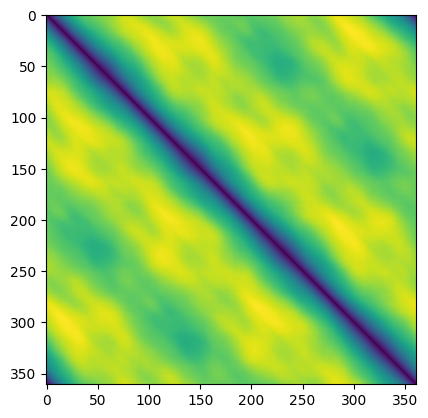

In [31]:
# c4 image, not as clean as you'd hope
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = img4.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (30,30),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5, metric = 'manhattan')
plt.figure()
plt.imshow(D)
plt.show()

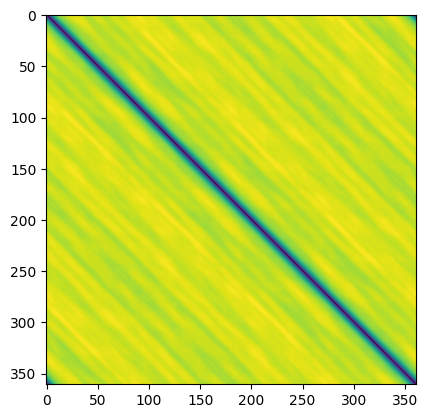

In [32]:
# c4 image biggest lense
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = img4.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (90,90),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5, metric = 'manhattan')
plt.figure()
plt.imshow(D)
plt.show()

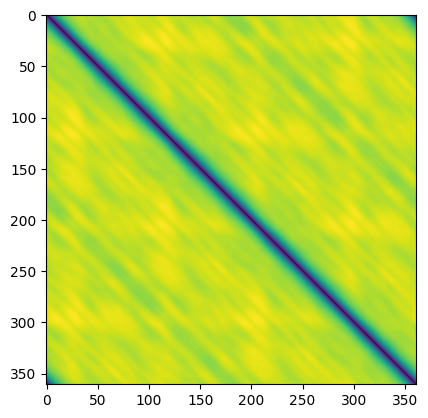

In [33]:
# c4 image again bigger lense, these seem noisy and bad
rot5 = []
j = np.arange(0,361,1)
for i in j:
    temp = img4.rotate(i, resample = PIL.Image.Resampling.BICUBIC)
    shower = translation_snapshot(temp, (60,60),(0,0))
    shower = np.asarray(shower)
    rot5.append(shower.reshape(-1))
D = pairwise_distances(rot5, metric = 'manhattan')
plt.figure()
plt.imshow(D)
plt.show()